# Modeling Electricity Consumption in the PJM Market
    The data refers to hourly consumption of electricity in the PJM market. It comprises two columns, the first column contains the day and the hour, and the second column contains the consumption. The dataset includes column headers in the first row: "Datetime" (timestamp) and "PJME_MW" (megawatts consumed). 


## Dependências

In [ ]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import random

## Inspeção Visual

Colunas do DataFrame: ['Datetime', 'AEP_MW']
Primeiros 5 valores de AEP_MW:
shape: (5, 1)
┌────────┐
│ AEP_MW │
│ ---    │
│ i64    │
╞════════╡
│ 14877  │
│ 14588  │
│ 14514  │
│ 14591  │
│ 14604  │
└────────┘

Últimos 5 valores de AEP_MW:
shape: (5, 1)
┌────────┐
│ AEP_MW │
│ ---    │
│ i64    │
╞════════╡
│ 21089  │
│ 20999  │
│ 20820  │
│ 20415  │
│ 19993  │
└────────┘


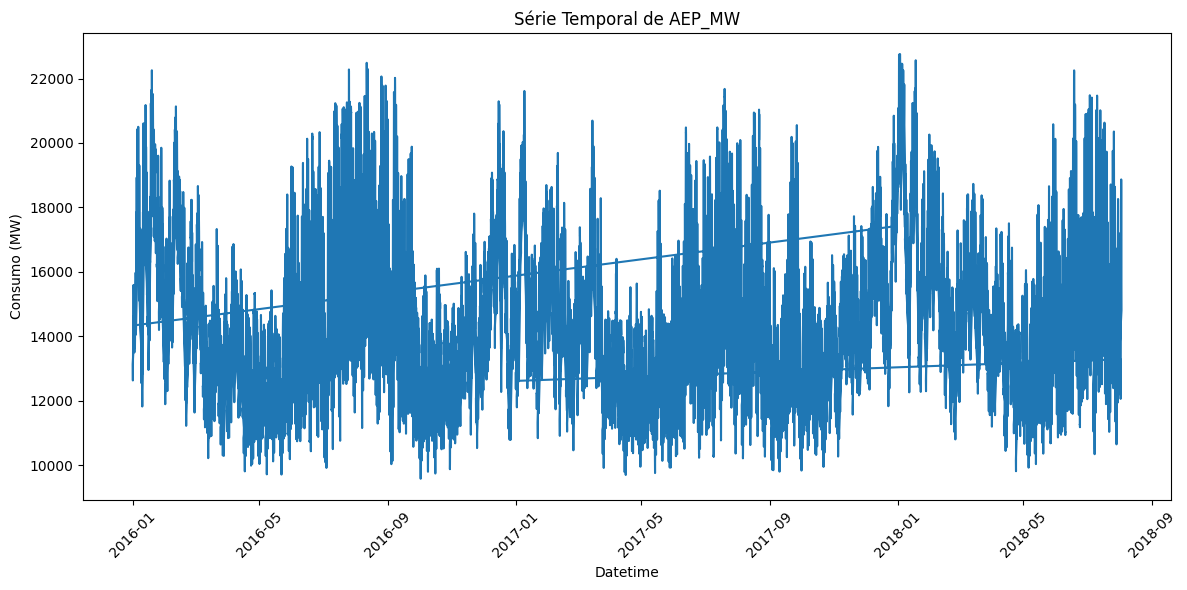

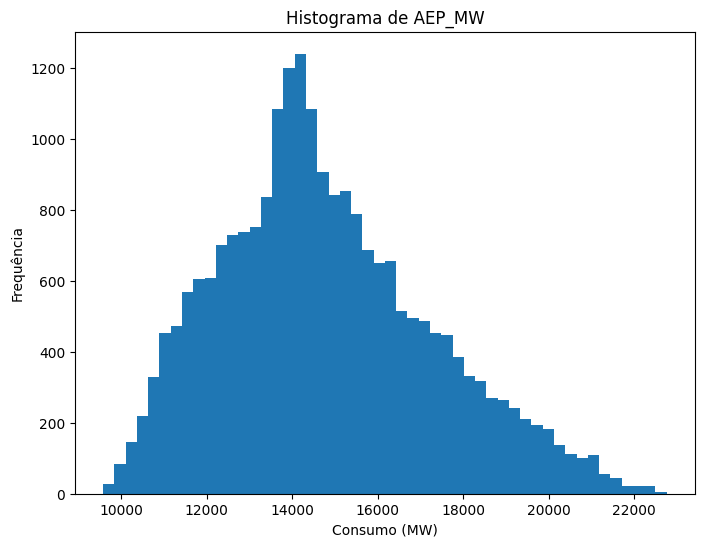

In [ ]:
class DataAnalyzer:
    def __init__(self, filepath: str):
        self.filepath = filepath
        self.df = None

    def load_data(self):
        self.df = pl.read_excel(self.filepath)
        print("Colunas do DataFrame:", self.df.columns)
        if self.df["Datetime"].dtype != pl.Datetime: #verific datetime
            self.df = self.df.with_columns(
                pl.col("Datetime").str.strptime(pl.Datetime, fmt="%Y-%m-%d %H:%M:%S")
            )
        return self.df

    def print_series_summary(self, column: str):
        if column not in self.df.columns:
            print(f"Coluna '{column}' não encontrada. Colunas disponíveis: {self.df.columns}")
            return
        print(f"Primeiros 5 valores de {column}:")
        print(self.df.select(column).head(5))
        print(f"\nÚltimos 5 valores de {column}:")
        print(self.df.select(column).tail(5))

    def plot_time_series(self, datetime_col: str, value_col: str):
        if datetime_col not in self.df.columns:
            print(f"Coluna '{datetime_col}' não encontrada. Colunas disponíveis: {self.df.columns}")
            return
        if value_col not in self.df.columns:
            print(f"Coluna '{value_col}' não encontrada. Colunas disponíveis: {self.df.columns}")
            return
        df_pd = self.df.to_pandas() # pra plotar
        plt.figure(figsize=(12, 6))
        plt.plot(df_pd[datetime_col], df_pd[value_col])
        plt.xlabel("Datetime")
        plt.ylabel("Consumo (MW)")
        plt.title("Série Temporal de {}".format(value_col))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_histogram(self, column: str, bins: int = 50):
        if column not in self.df.columns:
            print(f"Coluna '{column}' não encontrada. Colunas disponíveis: {self.df.columns}")
            return
        df_pd = self.df.to_pandas()
        plt.figure(figsize=(8, 6))
        plt.hist(df_pd[column], bins=bins)
        plt.xlabel("Consumo (MW)")
        plt.ylabel("Frequência")
        plt.title("Histograma de {}".format(column))
        plt.show()

# se for deixar em .py: NAO ESQUECER 
#if __name__ == "__main__":   ######################################################################
filepath = r"C:\Users\Leo\Desktop\Portfolio\EconDynamicsHub\Neural Network Introduction\AEP_hourly1.xlsx"
analyzer = DataAnalyzer(filepath)
analyzer.load_data()
analyzer.print_series_summary("AEP_MW")
analyzer.plot_time_series("Datetime", "AEP_MW")
analyzer.plot_histogram("AEP_MW", bins=50)
####################################################################################################


## Split cuidadoso dos dados 

In [ ]:
class RNNDataPreprocessor:
    def __init__(self, data, seed: int = 42):
        self.data = data
        self.seed = seed
        np.random.seed(self.seed)
        
    def normalize_data(self):
        self.min_val = np.min(self.data)
        self.max_val = np.max(self.data)
        self.data_normalized = (self.data - self.min_val) / (self.max_val - self.min_val)
        return self.data_normalized
    
    def split_data(self):

        if not hasattr(self, 'data_normalized'):
            raise ValueError("Os dados devem ser normalizados primeiro chamando o método normalize_data().")
        
        n = len(self.data_normalized)
        train_end = int(n * 0.7)
        val_end = train_end + int(n * 0.2)
        
        train_data = self.data_normalized[:train_end]
        val_data = self.data_normalized[train_end:val_end]
        test_data = self.data_normalized[val_end:]
        
        return train_data, val_data, test_data

if __name__ == "__main__":
    filepath = r"C:\Users\Leo\Desktop\Portfolio\EconDynamicsHub\Neural Network Introduction\AEP_hourly1.xlsx"
    df = pl.read_excel(filepath)
    
    if df["Datetime"].dtype != pl.Datetime:
        df = df.with_columns(
            pl.col("Datetime").str.strptime(pl.Datetime, fmt="%Y-%m-%d %H:%M:%S")
        )
    
    data_series = df["AEP_MW"].to_numpy()
    
    preprocessor = RNNDataPreprocessor(data_series, seed=42)
    data_normalized = preprocessor.normalize_data()
    train_data, val_data, test_data = preprocessor.split_data()
    
    print("Formato dos dados:")
    print("Treinamento:", train_data.shape)
    print("Validação:", val_data.shape)
    print("Teste:", test_data.shape)


Formato dos dados:
Treinamento: (15875,)
Validação: (4535,)
Teste: (2269,)


In [ ]:
##################### helpers ###########################################
def relu(x):
    return np.maximum(0, x)
def relu_derivative(x):
    return (x > 0).astype(float)

class Dropout:   # fwd  bckwd   
    def __init__(self, dropout_rate, seed=42):
        self.rate = dropout_rate
        self.seed = seed
        
    def forward(self, X, training=True):
        if training:
            np.random.seed(self.seed) 
            self.mask = (np.random.rand(*X.shape) >= self.rate).astype(float) / (1 - self.rate)
            return X * self.mask
        else:
            return X

    def backward(self, dY):
        return dY * self.mask
class DenseLayer:   # tot cnctd  
    def __init__(self, input_dim, output_dim, seed=42):
        np.random.seed(seed)
        self.W = np.random.randn(input_dim, output_dim) * np.sqrt(2. / input_dim)
        self.b = np.zeros((1, output_dim))
    
    def forward(self, X):
        self.X = X  # Armazena para o backprop
        return np.dot(X, self.W) + self.b

    def backward(self, d_out, learning_rate):
        dW = np.dot(self.X.T, d_out)
        db = np.sum(d_out, axis=0, keepdims=True)
        dX = np.dot(d_out, self.W.T)
        self.W -= learning_rate * dW  #atualiz os parms
        self.b -= learning_rate * db
        return dX

#########################   camada RNN   ################################
class RNNLayer:
    def __init__(self, input_dim, hidden_dim, return_sequences=True, seed=42):
        np.random.seed(seed)
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.return_sequences = return_sequences
        # ----->  pesos de entrada , recorrentes
        self.Wx = np.random.randn(input_dim, hidden_dim) * np.sqrt(2. / input_dim)
        self.Wh = np.random.randn(hidden_dim, hidden_dim) * np.sqrt(2. / hidden_dim)
        self.b = np.zeros(hidden_dim)
    
    def forward(self, X, training=True):
        # X: shape (batch, seq_length, input_dim)
        batch_size, seq_length, _ = X.shape
        self.x = X
        self.h = np.zeros((batch_size, seq_length, self.hidden_dim))
        self.z = np.zeros((batch_size, seq_length, self.hidden_dim))
        # xomeça com zeros de estado inicial
        h_prev = np.zeros((batch_size, self.hidden_dim))
        for t in range(seq_length):
            self.z[:, t, :] = np.dot(X[:, t, :], self.Wx) + np.dot(h_prev, self.Wh) + self.b
            self.h[:, t, :] = relu(self.z[:, t, :])
            h_prev = self.h[:, t, :].copy()
        return self.h if self.return_sequences else self.h[:, -1, :]
    
    def backward(self, d_out, learning_rate):
        #---------->  d_out: gradiente vindo da camada seguinte.
        batch_size, seq_length = self.x.shape[0], self.x.shape[1]
        dWx = np.zeros_like(self.Wx)
        dWh = np.zeros_like(self.Wh)
        db = np.zeros_like(self.b)
        dX = np.zeros_like(self.x)
        dh_next = np.zeros((batch_size, self.hidden_dim))
        
        #---------->  aqui eu vou organizar o gradiente p todos os timesteps
        if not self.return_sequences:
            d_h = np.zeros((batch_size, seq_length, self.hidden_dim))
            d_h[:, -1, :] = d_out
        else:
            d_h = d_out
        
        #---------->  BPTT
        for t in reversed(range(seq_length)):
            dh = d_h[:, t, :] + dh_next  # soma do gradiente c o do prox timestep
            dz = dh * relu_derivative(self.z[:, t, :])
            db += np.sum(dz, axis=0)
            dWx += np.dot(self.x[:, t, :].T, dz)
            h_prev = self.h[:, t-1, :] if t > 0 else np.zeros((batch_size, self.hidden_dim))
            dWh += np.dot(h_prev.T, dz)
            dX[:, t, :] = np.dot(dz, self.Wx.T)
            dh_next = np.dot(dz, self.Wh.T)
        
        # ---------->  params atualizados <-----------------
        self.Wx -= learning_rate * dWx
        self.Wh -= learning_rate * dWh
        self.b  -= learning_rate * db
        
        return dX

#########################   classe final  ###############################
class RNNModel:
    def __init__(self, seed=42):
        self.rnn1 = RNNLayer(input_dim=1, hidden_dim=64, return_sequences=True, seed=seed)
        self.dropout1 = Dropout(dropout_rate=0.3, seed=seed)
        self.rnn2 = RNNLayer(input_dim=64, hidden_dim=32, return_sequences=False, seed=seed)
        self.dropout2 = Dropout(dropout_rate=0.3, seed=seed)
        self.dense = DenseLayer(input_dim=32, output_dim=1, seed=seed)
    
    def forward(self, X, training=True):
        out1 = self.rnn1.forward(X, training)
        out1 = self.dropout1.forward(out1, training)
        out2 = self.rnn2.forward(out1, training)
        out2 = self.dropout2.forward(out2, training)
        out = self.dense.forward(out2)
        return out
    
    def backward(self, d_out, learning_rate):
        d_dense = self.dense.backward(d_out, learning_rate)
        d_dropout2 = self.dropout2.backward(d_dense)
        d_rnn2 = self.rnn2.backward(d_dropout2, learning_rate)
        d_dropout1 = self.dropout1.backward(d_rnn2)
        self.rnn1.backward(d_dropout1, learning_rate)


def create_sequences(data, seq_length):
    """Cria seqs e rótulos p o treino"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)
def denormalize(normalized_data, data_min, data_max):
    return normalized_data * (data_max - data_min) + data_min



## Main: treinamento

In [15]:
#################### IMPORTANDO DADOS COM SEQUÊNCIAS  ########################################
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
#########  importando dados de novo    #######################################################   
filepath = r"C:\Users\Leo\Desktop\Portfolio\EconDynamicsHub\Neural Network Introduction\AEP_hourly1.xlsx"
df = pl.read_excel(filepath)
if df["Datetime"].dtype != pl.Datetime:  #(não usada no treinamento)
    df = df.with_columns(pl.col("Datetime").str.strptime(pl.Datetime, fmt="%Y-%m-%d %H:%M:%S"))

##############  serie em np e normalizacao  #################################################
data_series = df["AEP_MW"].to_numpy()
data_min = np.min(data_series)
data_max = np.max(data_series)
data_normalized = (data_series - data_min) / (data_max - data_min)

##############  Criar sequs  ###########################################################
SEQ_LENGTH = 24  # faz sentido por ser diário  
X, y = create_sequences(data_normalized, SEQ_LENGTH)
X = X.reshape((X.shape[0], X.shape[1], 1))  # fica assim : (samples, timesteps, features)
####################### SPLIT DOS DADOS ################################################
############  Re-dividir os dados 70% T, 20% V, 10% T  ##################################
n_samples = X.shape[0]
train_end = int(n_samples * 0.7)
val_end = train_end + int(n_samples * 0.2)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

print("Shapes dos dados:")
print("Treino:", X_train.shape, y_train.shape)
print("Validação:", X_val.shape, y_val.shape)
print("Teste:", X_test.shape, y_test.shape)

##########################################################################################
#----------------------------------------------------------------------------------------
# ----------------------->  TREINAMENTO   <----------------------------------------------
#----------------------------------------------------------------------------------------
##########################################################################################

#################         HIPERPARÂMETROS        #########################################
model = RNNModel(seed=SEED)
epochs = 50
batch_size = 32
learning_rate = 0.001
patience = 5
#######  calibração ####################################################################
best_val_loss = np.inf
wait = 0
history = {"train_loss": [], "val_loss": []}

for epoch in range(epochs):   
    perm = np.random.permutation(X_train.shape[0])  # Embaralhar os dados
    X_train = X_train[perm]
    y_train = y_train[perm]
    
    train_loss = 0
    num_batches = int(np.ceil(X_train.shape[0] / batch_size))
    
    for i in range(num_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, X_train.shape[0])
        X_batch = X_train[start:end]
        y_batch = y_train[start:end].reshape(-1, 1)
        
        #-------------------->  Forward pass
        predictions = model.forward(X_batch, training=True)
        loss = np.mean((predictions - y_batch) ** 2)
        train_loss += loss * (end - start)
        
        #------------>  Backward pass- derivada do MSE
        d_loss = (2 * (predictions - y_batch)) / y_batch.shape[0]
        model.backward(d_loss, learning_rate)
    
    train_loss /= X_train.shape[0]
    history["train_loss"].append(train_loss)
    
    #----------------->  Cálculo da loss
    val_predictions = model.forward(X_val, training=False)
    val_loss = np.mean((val_predictions - y_val.reshape(-1, 1)) ** 2)
    history["val_loss"].append(val_loss)
    ############   "verbose" é true, basta comentar abaixo e nao quiser
    print(f"Epoch {epoch+1:02d} - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}")
    
    # EarlyStop: para se não houver melhora por n=='patience' épocas
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break




Shapes dos dados:
Treino: (15858, 24, 1) (15858,)
Validação: (4531, 24, 1) (4531,)
Teste: (2266, 24, 1) (2266,)
Epoch 01 - Train Loss: 0.178169 - Val Loss: 0.014410
Epoch 02 - Train Loss: 0.021888 - Val Loss: 0.009141
Epoch 03 - Train Loss: 0.015021 - Val Loss: 0.008276
Epoch 04 - Train Loss: 0.012080 - Val Loss: 0.007795
Epoch 05 - Train Loss: 0.010473 - Val Loss: 0.007804
Epoch 06 - Train Loss: 0.009402 - Val Loss: 0.007729
Epoch 07 - Train Loss: 0.008533 - Val Loss: 0.007549
Epoch 08 - Train Loss: 0.007898 - Val Loss: 0.007395
Epoch 09 - Train Loss: 0.007307 - Val Loss: 0.007130
Epoch 10 - Train Loss: 0.006823 - Val Loss: 0.006957
Epoch 11 - Train Loss: 0.006270 - Val Loss: 0.007053
Epoch 12 - Train Loss: 0.005893 - Val Loss: 0.006728
Epoch 13 - Train Loss: 0.005606 - Val Loss: 0.006811
Epoch 14 - Train Loss: 0.005275 - Val Loss: 0.006590
Epoch 15 - Train Loss: 0.005054 - Val Loss: 0.006653
Epoch 16 - Train Loss: 0.004863 - Val Loss: 0.006751
Epoch 17 - Train Loss: 0.004674 - Val Lo

## Resultados


Métricas no conjunto de Validação:
MSE: 1174304.238 | MAPE: 5.635%

Métricas no conjunto de Teste:
MSE: 1954624.970 | MAPE: 6.986%


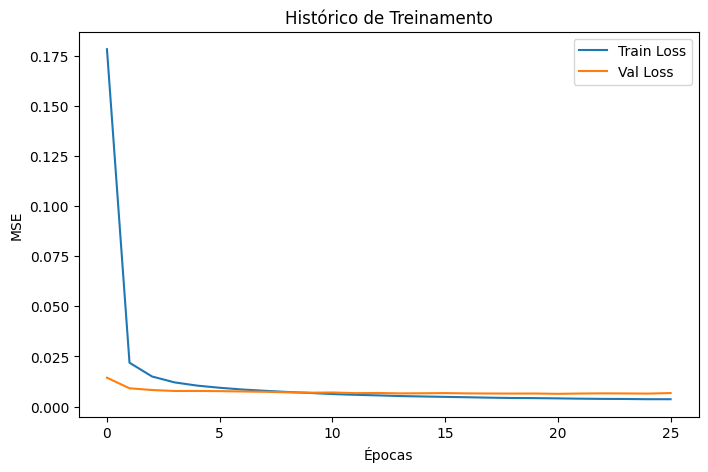

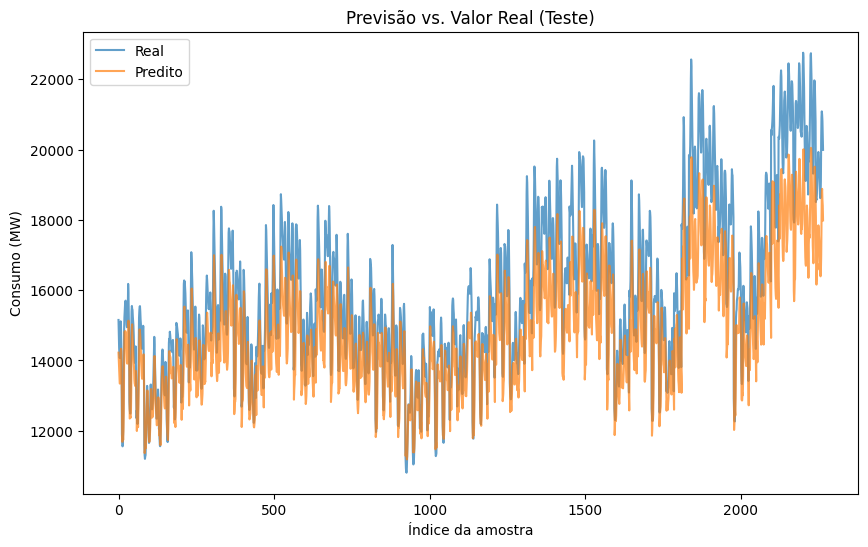

In [16]:
######## ------ Previsões ------ ########### 
#validacao
pred_val_norm = model.forward(X_val, training=False)
pred_val_denorm = denormalize(pred_val_norm, data_min, data_max)
y_val_denorm = denormalize(y_val.reshape(-1, 1), data_min, data_max)
#teste: 
pred_test_norm = model.forward(X_test, training=False)
pred_test_denorm = denormalize(pred_test_norm, data_min, data_max)
y_test_denorm = denormalize(y_test.reshape(-1, 1), data_min, data_max)

######## ------ MSE MAPE ------ ########### 
def compute_metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, mape

val_mse, val_mape = compute_metrics(y_val_denorm, pred_val_denorm)
test_mse, test_mape = compute_metrics(y_test_denorm, pred_test_denorm)

print("\nMétricas no conjunto de Validação:")
print(f"MSE: {val_mse:.3f} | MAPE: {val_mape:.3f}%")
print("\nMétricas no conjunto de Teste:")
print(f"MSE: {test_mse:.3f} | MAPE: {test_mape:.3f}%")

######## ------ Plot Histórico ------ ########### 
plt.figure(figsize=(8, 5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.title("Histórico de Treinamento")
plt.legend()
plt.show()

######## ------ Real vs Predito  ------ ########### 
plt.figure(figsize=(10, 6))
plt.plot(y_test_denorm, label="Real", alpha=0.7)
plt.plot(pred_test_denorm, label="Predito", alpha=0.7)
plt.xlabel("Índice da amostra")
plt.ylabel("Consumo (MW)")
plt.title("Previsão vs. Valor Real (Teste)")
plt.legend()
plt.show()
##################################################